In [537]:
import torch
import torchvision
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import torch.nn.functional as F


from time import time
from mpl_toolkits import mplot3d
from torchvision import datasets, transforms
from torch import nn, optim
from torch import autograd

In [470]:
epoch = 5

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [ ]:
train_set = datasets.MNIST('./data/train/', 
                           download  = True, 
                           train     = True, 
                           transform = transform)

In [4]:
test_set = datasets.MNIST('./data/test/', 
                          download  = True, 
                          train     = False, 
                          transform = transform)



  3%|██▎                                                                   | 319488/9912422 [00:04<04:14, 37676.57it/s]

  3%|██▎                                                                   | 327680/9912422 [00:04<04:29, 35564.78it/s]

  3%|██▎                                                                   | 335872/9912422 [00:05<05:28, 29126.67it/s]

  4%|██▍                                                                   | 352256/9912422 [00:05<04:07, 38568.00it/s]

  4%|██▌                                                                   | 368640/9912422 [00:05<03:29, 45601.14it/s]

  4%|██▊                                                                   | 393216/9912422 [00:05<02:41, 59090.65it/s]

  4%|███                                                                   | 425984/9912422 [00:05<02:06, 75061.79it/s]

  5%|███▏                                                                  | 450560/9912422 [00:05<01:44, 90855.29it/s]

  5%|███▎                     

Extracting ./data/test/MNIST\raw\train-images-idx3-ubyte.gz





0it [00:00, ?it/s]


  0%|                                                                                        | 0/28881 [00:00<?, ?it/s]


 28%|████████████████████▉                                                     | 8192/28881 [00:00<00:00, 39517.44it/s]


32768it [00:00, 55529.05it/s]                                                                                          

Extracting ./data/test/MNIST\raw\train-labels-idx1-ubyte.gz





0it [00:00, ?it/s]


  0%|                                                                                      | 0/1648877 [00:00<?, ?it/s]


  0%|▎                                                                       | 8192/1648877 [00:00<00:51, 31943.95it/s]


  1%|█                                                                      | 24576/1648877 [00:00<00:39, 41359.58it/s]


  3%|██                                                                     | 49152/1648877 [00:00<00:29, 53661.13it/s]


  4%|██▊                                                                    | 65536/1648877 [00:01<00:26, 60769.12it/s]


  5%|███▌                                                                   | 81920/1648877 [00:01<00:22, 69711.03it/s]


  6%|████▏                                                                  | 98304/1648877 [00:01<00:19, 80546.50it/s]


  7%|████▊                                                                 | 114688/1648877 [00:01<00:20, 74772.73it/s]




Extracting ./data/test/MNIST\raw\t10k-images-idx3-ubyte.gz






0it [00:00, ?it/s]



  0%|                                                                                         | 0/4542 [00:00<?, ?it/s]



8192it [00:00, 34149.24it/s]                                                                                           

Extracting ./data/test/MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!





1654784it [00:43, 14478.67it/s]                                                                                        

In [478]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [535]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1 = nn.Linear(400, 64)
        self.fc2 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.normalize(x)
        return x

In [475]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embedding = Embedding()
    
    def forward(self, a, p, n):
        a = self.embedding(a)
        p = self.embedding(p)
        n = self.embedding(n)
        return torch.cat((a, p, n), dim = -1)

In [543]:
def get_distance(data):
    dot_product = torch.matmul(data, data.transpose(1, 0))
    diag        = torch.diag(dot_product)
    distances   = diag.view((1, diag.shape[0])) - 2*dot_product + diag.view((diag.shape[0], 1))
    distances   = torch.max(distances, torch.tensor([0]).float())
    mask        = torch.eq(distances, torch.zeros(1)).float()
    distances   = distances + mask * 1e-16
    distances   = torch.sqrt(distances)
    distances   = distances * (1.0 - mask)
    return distances

In [432]:
def get_mask_triplet(labels):
    hot = F.one_hot(labels)
    positive_mask = torch.matmul(hot, hot.transpose(0, 1))
    size = positive_mask.shape[0]
    positive_mask[range(size), range(size)] = torch.zeros(positive_mask.shape[0]).long()
    negative_mask = torch.matmul(torch.ones(hot.shape).long() - hot, hot.transpose(0, 1))
    mask = torch.matmul(positive_mask.view((size, size, 1)), negative_mask.view((size, 1, size)))
    return mask

In [482]:
def triplet_loss(data, labels, m):
    distances = get_distance(data)
    size = distances.shape[0]
    delta_p   = distances.view((size, size, 1)).repeat((1, 1, size))
    delta_n   = distances.view((size, 1, size)).repeat((1, size, 1))
    triplet_loss = delta_p - delta_n + m
    mask      = get_mask_triplet(labels).float()
    triplet_loss = triplet_loss * mask
    triplet_loss = torch.max(triplet_loss, torch.zeros(1).float())
    
    nb_of_tensor = torch.gt(triplet_loss, torch.tensor([1e-16]).float())
    nb_of_tensor = torch.sum(nb_of_tensor)
    triplet_loss = torch.sum(triplet_loss)
    return triplet_loss / (nb_of_tensor + torch.tensor([1e-16]).float())

In [544]:
net = Embedding()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

In [545]:
for e in range(epoch):
    running_loss = 0
    for data, labels in train_loader:
        with autograd.detect_anomaly():
            optimizer.zero_grad()
            out  = net(data)
            loss = triplet_loss(out, labels, torch.tensor([1]).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))

Epoch 0 - Training loss: 0.4062634387691816
Epoch 1 - Training loss: 0.26852808459599814
Epoch 2 - Training loss: 0.26002932659089567
Epoch 3 - Training loss: 0.2640387127776941
Epoch 4 - Training loss: 0.38016002607047555


In [546]:
data_movie, labels_movie = [], []
for data, labels in train_loader:
    for i in net(data):
        data_movie.append(i.detach().numpy())
    for i in labels:
        labels_movie.append(i.detach().numpy())
    if len(data_movie) >= 500:
        break
data_movie = np.array(data_movie)
labels_movie = np.array(labels_movie)

In [547]:
def visual(x, y):
    palette = np.array(sns.color_palette("hls", 10))
    fig = plt.figure(figsize=(12, 11))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                      c=palette[y.astype(np.int)]);
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_zlim(-1.5, 1.5)


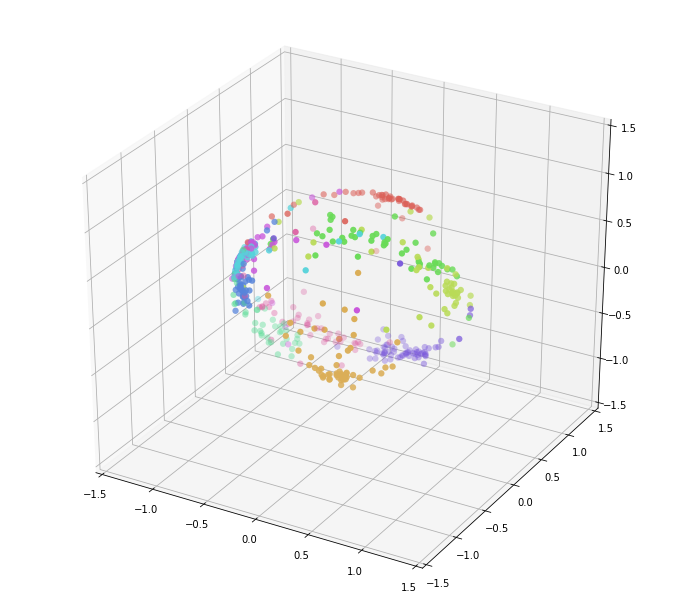

In [548]:
visual(data_movie, labels_movie)

In [91]:
def triplet_loss(inputs, m):
    anchor, positive, negative = torch.chunk(inputs, 3, dim = 0)
    delta_p = F.pairwise_distance(anchor, positive)
    delta_n = F.pairwise_distance(anchor, negative)
    loss = torch.max(delta_p - delta_n + m, torch.zeros(1))
    return loss

In [532]:
net

Embedding(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)